# simple RNN 이용한 SMS spam 분류

In [1]:
import pandas as pd
url = 'https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv'

In [3]:
df = pd.read_csv(url, encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### 데이터 전처리

In [4]:
# Selection
df = df[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# null 데이터 확인
df.isna().sum().sum()

0

In [7]:
# 중복 데이터 확인
df.shape, df.v2.nunique()

((5572, 2), 5169)

In [8]:
df.drop_duplicates(subset=['v2'], inplace=True)
df.shape

(5169, 2)

In [9]:
# ['ham', 'spam'] => [0,1]
df.v1 = df.v1.replace(['ham', 'spam'], [0,1])
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# Ham/Spam 분포
df.v1.value_counts()

0    4516
1     653
Name: v1, dtype: int64

In [11]:
# 전처리 완료된 파일 만들어두기
df.to_csv('spam전처리_완료.csv', index=False)

In [12]:
x, y = df.v2.values, df.v1.values
x.shape, y.shape

((5169,), (5169,))

## Keras 텍스트 전처리

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
import re
# encoding, 구둣점 제거, 소문자로 변환
import matplotlib.pyplot as plt
def preprocessing(s):
    s = s.encode('utf8').decode('ascii', 'ignore')
    s = re.sub('[^A-Za-z0-9 ]', '', s.lower())
    return s

In [18]:
X_data = [preprocessing(sent) for sent in x]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [19]:
t=Tokenizer()
t.fit_on_texts(X_data) 
vocab_size = len(t.word_index)+1
vocab_size

9479

In [21]:
sequences = t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]
[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [22]:
max_len =max(len(seq) for seq in sequences)
max_len

171

In [23]:
# 전체 데이터를 max_len 길이 맞추도록 padding
data = pad_sequences(sequences, maxlen=max_len)

 - train / test dataset 분리

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, stratify=y, test_size=0.2, random_state=2022)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

### 모델 정의 / 설정 / 학습 / 평가

In [25]:
import numpy as np
import tensorflow as tf
seed =2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [28]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [30]:
model = Sequential(
    [Embedding(vocab_size, 32, input_length=max_len),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 171, 32)           303328    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 305,441
Trainable params: 305,441
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile('adam','binary_crossentropy', ['accuracy'])

In [32]:
model_path = 'best_spam_rnn.h5'
mc = ModelCheckpoint(model_path, verbose=1, save_best_only=True)
es = EarlyStopping(patience=10)

In [33]:
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[mc,es])

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.8558
Epoch 1: val_loss improved from inf to 0.24656, saving model to best_spam_rnn.h5
52/52 [==============================] - 6s 64ms/step - loss: 0.4025 - accuracy: 0.8558 - val_loss: 0.2466 - val_accuracy: 0.8984
Epoch 2/100
51/52 [============================>.] - ETA: 0s - loss: 0.1694 - accuracy: 0.9516
Epoch 2: val_loss improved from 0.24656 to 0.12403, saving model to best_spam_rnn.h5
52/52 [==============================] - 3s 53ms/step - loss: 0.1692 - accuracy: 0.9516 - val_loss: 0.1240 - val_accuracy: 0.9686
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 0.0726 - accuracy: 0.9844
Epoch 3: val_loss improved from 0.12403 to 0.09619, saving model to best_spam_rnn.h5
52/52 [==============================] - 3s 53ms/step - loss: 0.0722 - accuracy: 0.9843 - val_loss: 0.0962 - val_accuracy: 0.9722
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.038

In [34]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

33/33 [==============================] - 1s 23ms/step - loss: 0.0668 - accuracy: 0.9807


[0.06676517426967621, 0.9806576371192932]

 - 학습과정 시각화

In [37]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1,len(y_acc)+1)

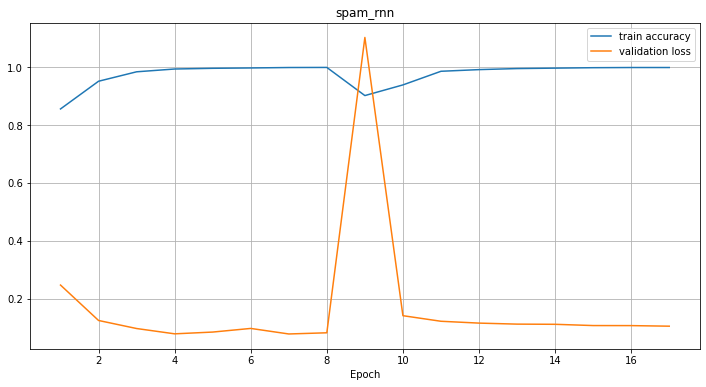

In [38]:
plt.figure(figsize=(12,6))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend(), plt.grid()
plt.xlabel('Epoch')
plt.title('spam_rnn')
plt.show()